# Computational Tomography of Chemiluminescence using Sparse Sensing

## CTC

The CTC problem is essentially an inversion problem in which the objective is to reconstruct the 3D field $\bm{f}(x_f,y_f,z_f)$, given its projection on the camera sensor $\bm{p}(x_p,y_p)$ and the point spread function $\bm{C}(x_f,y_f,z_f,x_p,y_p)$ that relates the amount of light produced by a point source onto the sensor’s plane:

\begin{equation}
    \bm{p} = \bm{C} \bm{f},
\end{equation}
where $\bm{p}$ has dimensions $s \times 1$,  $\bm{f}$ has dimensions $n \times 1$ and $\bm{C}$ has dimensions $s \times n$.

<img src="https://drive.google.com/uc?id=1AHlm65f7TyGXlp_vChfXMIYJaXPptuHC" alt="CTC diagram" style="height: 300px; width:600px;"/>

The figure shows a schematic representation of the CTC mathematical framework. In computed tomography, $\bm{f}$ is usually discretized into $n$ voxels and the light emitted from each voxel is focused by the camera system onto the sensor’s plane. 
The size $s$ of $\bm{p}$ depends on the number of pixels in the $x_p$ and $y_p$ directions, as well as on the number of images taken, such that $s=n_{x_p} \times n_{y_p} \times n_i$.

The point spread function depends only on the position and characteristics of the camera system. The computation of $\bm{C}$ is essentially a ray-tracing problem, where the objective is to compute the light's path from the source to the observer. 
The size of $\bm{C}$ can quickly become computationally challenging. For example, if the system is discretized using $n = 64 \times 64 \times 64$ and the resolution of the sensor is $512 \times 512$ with 5 cameras installed, the size of $\bm{C} = s \times n = 389120 \times 262144$.
However, $\bm{C}$ is a sparse matrix, and this characteristic can be exploited to reduce the computational and storage requirements.

## CTC with Sparse Sensing

The first step in the sparse sensing algorithm is to reduce the dimensionality of the system’s state $\bm{f}$ by finding a transforming basis $\bm{\Phi}_r$, such that:
\begin{equation}
    \bm{f} = \bm{\Phi}_r \bm{\psi},
\end{equation}
where $\bm{\Phi}_r$ has dimensions $n \times r$, $\bm{\psi}$ has dimensions $r \times 1$ and the size $r$ of the low-dimensional vector $\bm{\psi}$ is generally much smaller than $n$.

To compute the POD basis, we can employ the Singular Value Decomposition (SVD):

\begin{equation}
    \bm{F}(\bm{r}, t) = \bm{U}(\bm{r}) \bm{\Sigma} \bm{V}^T (t)
\end{equation}

The matrix $\bm{F}$ contains $m$ system’s states $\bm{f}$ arranged as column vectors. In our case, $\bm{F}$ includes multiple timesteps of the 3D chemiluminescence field. The matrix $\bm{U}$ contains the spatial modes, while the matrix $\bm{V}$ contains the POD temporal coefficients. The matrix $\bm{\Sigma}$ is a diagonal matrix containing the singular values, which are a measure of the amount of information captured by each mode. 

The linear system can be then rewritten as:

\begin{equation}
    \bm{p} = \bm{C} \bm{f} = \bm{C} \bm{U}_r \bm{a} = \bm{\Theta} \bm{a},
\end{equation}

where $\bm{a}$ is the low-dimensional POD projection of $\bm{f}$, and $\bm{U}_r$ is the $r$-order truncation of the matrix $\bm{U}$. The matrix $\bm{\Theta}$ has dimensions $s \times r$, and the conditioning number of this matrix is much lower than the conditioning number of the matrix $\bm{C}$, provided that some conditions between the placement of sensors with respect to the POD modes are met. This means that the new linear system can be solved by inverting the matrix $\bm{\Theta}$, using conventional approaches such as least-squares regression. 

To improve the prediction accuracy of the low-dimensional projection, physical constraints such as positivity can be introduced, so that the constrained objective function becomes:
\begin{align}
\begin{split}
\bm{a}^* = \underset{\bm{a}}{\textrm{argmin}}  & \  \mid \mid \bm{y} - \bm{\Theta} \bm{a} \mid \mid ^2_2, \\
\textrm{s.t.}  & \  \bm{U}_r \bm{a} > 0.
\end{split}
\end{align}
Once the low-dimensional vector $\bm{a}^*$ has been computed, the chemiluminescence field can be reconstructed as:
\begin{equation}
    \bm{f} = \bm{U}_r \bm{a}^*
\end{equation}

## Example

The first cell is used to download the dataset from zenodo using the ```zenodo_get ``` command. This command can be installed via:
```console
pip install zenodo_get
```
Otherwise, the dataset can be downloaded directly from [zenodo](https://www.zenodo.org/record/7786311).

In [1]:
import zenodo_get

! zenodo_get -d 10.5281/zenodo.7786311
! unzip DT_dataset.zip

Title: Numerical simulations and experimental measurements of the ULB semi-industrial furnace for the development of a Digital Twin
Keywords: Digital Twin, Flameless combustion, Furnace, CFD, Temperature measurements
Publication date: 2023-08-30
DOI: 10.5281/zenodo.8300372
Total size: 748.7 MB

Link: https://zenodo.org/api/files/90435c77-6765-4d50-b5c2-96155fcc0c6a/DT_dataset.zip   size: 748.7 MB
100% [..................................................] 785063300 / 785063300
Checksum is correct. (c9aeb72b44088a7cc53c7470d3d435f6)
All files have been downloaded.
Archive:  DT_dataset.zip
   creating: DT_dataset/
   creating: DT_dataset/Numerical_data/
  inflating: __MACOSX/DT_dataset/._Numerical_data  
  inflating: DT_dataset/.DS_Store    
  inflating: __MACOSX/DT_dataset/._.DS_Store  
  inflating: DT_dataset/grid.vtu     
  inflating: __MACOSX/DT_dataset/._grid.vtu  
  inflating: DT_dataset/cases_parameters.csv  
  inflating: __MACOSX/DT_dataset/._cases_parameters.csv  
  inflating: DT_

Here we import some libraries and we create the data matrix `X` that contains the 45 simulations.

In [2]:
import glob
import numpy as np
import pandas as pd
from scipy.interpolate import griddata

def read_simulation(filepath):
    sim = np.array(pd.read_csv(filepath))
    xyz = np.array(sim[:,1:4])

    column = np.empty((n, ))
    for i, f in enumerate(features):
        if xyz.shape[0] != n_cells:
            column[i*n_cells:(i+1)*n_cells] = griddata(xyz, sim[:,4+i], xyz_25, method='nearest')
        else:
            column[i*n_cells:(i+1)*n_cells] = sim[:,4+i]

    return column

path = './DT_dataset'

P_df = pd.read_csv(f'{path}/cases_parameters.csv')
P = np.array(P_df.iloc[:,2:])
m = P.shape[0]

features = ['NOx', 'CO', 'OH', 'H2', 'H2O', 'CO2', 'O2', 'CH4', 'T']
n_features = len(features)

# The simulations with different inlet diameter use different grids.
# We interpolate them on the coarsest grid, which is the one for D=25mm.

filepath = glob.glob(f'{path}/Numerical_data/Case6_*')
xyz_25 = np.array(pd.read_csv(filepath[0]).iloc[:,1:4])
n_cells = xyz_25.shape[0]

n = n_features*n_cells
X = np.empty((n,m))
for i in range(P_df.shape[0]):
    filepath =  glob.glob(f'{path}/Numerical_data/Case{P_df.iloc[i,1]}_*')
    X[:,i] = read_simulation(filepath[0])
    print(f'Simulation {i+1}/{m}', end='\r', flush=True)


Here we import pyvista to plot a slice of one simulation.

2024-02-26 16:32:34.573 (2487.794s) [          2F3921]      vtkPolyhedron.cxx:1777  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


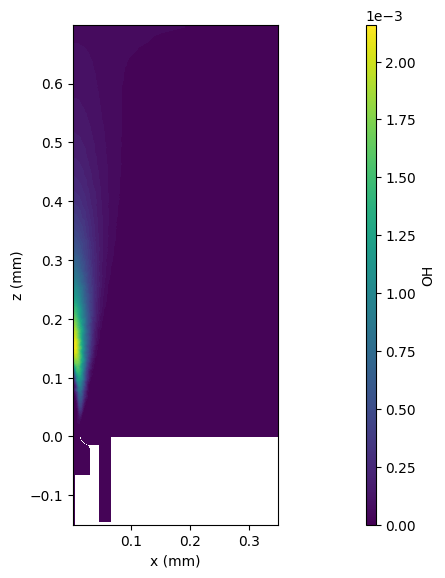

In [44]:
import pyvista as pv
import matplotlib as mpl
import matplotlib.pyplot as plt

def plot_slice(mesh, z, normal, origin, axis, feature):
    mesh['z'] = z        
    plane = mesh.ctp().slice(normal=normal, origin=origin, generate_triangles=True)
    
    vmin = plane['z'].min()
    vmax = plane['z'].max()

    x = plane.points
    tri = plane.faces.reshape((-1,4))[:, 1:]
    
    fig, ax = plt.subplots(figsize=(4,5))
    levels = 64

    axis_labels = ['x', 'y', 'z']
    fig.subplots_adjust(bottom=0., top=1., left=0, right=.95, wspace=0., hspace=0.0)

    cs = ax.tricontourf(x[:,axis[0]], x[:,axis[1]], tri, plane['z'], cmap='viridis',
                        levels=levels)
    
    ax.set_aspect('equal')
    ax.set_xlabel(f'{axis_labels[axis[0]]} (mm)')
    ax.set_ylabel(f'{axis_labels[axis[1]]} (mm)')
    
    ax_bounds = ax.get_position().bounds
    cb_ax = fig.add_axes([0.95, ax_bounds[1], 0.025, ax_bounds[3]])
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='viridis'), 
                        cax=cb_ax, orientation='vertical', label=feature)
    fmt = mpl.ticker.ScalarFormatter(useMathText=True)
    cbar.formatter.set_powerlimits((0, 4))
    cb_ax.yaxis.set_offset_position('left')
    
    plt.show()

# read the mesh using Pyvista
mesh = pv.read(f'{path}/grid.vtu')

feature = 'OH'
i_feature = features.index(feature)

plot_slice(mesh, X[i_feature*n_cells:(i_feature+1)*n_cells,0], (0,1,0), (0.0, 1.0e-3, 0), (0,2), feature)

## Simulate the OH* emission

We use the tools in `utils` to simulate the OH* emission. We use OH as a surrogate of OH*.


In [45]:
# Store every fields in the mesh object
for i in range(n_features):
    for j in range(X.shape[1]):
        mesh.cell_data.set_array(X[i*n_cells:(i+1)*n_cells, j], f'f{i}/p{j}')
        print(f'Storing snapshot {j+1}/{X.shape[1]}', end='\r', flush=True)

# Then, we need to generate the global mesh considering the symmetry plane

mesh_mirr = mesh.reflect((1,-1,0), point=(0,0,0))
block1 = mesh.merge(mesh_mirr)
block2 = block1.reflect((1,0,0), point=(0,0,0))
block3 = block1.reflect((0,1,0), point=(0,0,0))
block4 = block1.reflect((1,1,0), point=(0,0,0))

mesh_glob = block1.merge([block2, block3, block4])
n_cells_glob = mesh_glob.n_cells
    
# Retrieve all the fields
X_glob = np.zeros((n_features*n_cells_glob, X.shape[1]))
for i in range(n_features):
    for j in range(X.shape[1]):
        tmp = mesh_glob.cell_data[f'f{i}/p{j}']
        X_glob[i*n_cells_glob:(i+1)*n_cells_glob, j] = tmp
        print(f'Retrieving snapshot {j+1}/{X.shape[1]}', end='\r', flush=True)

# Clear the data in the mesh objects
mesh.clear_data()
mesh_glob.clear_data()

xyz_int = mesh_glob.cell_centers().points

In [46]:
# Then, we sample the mesh on a voxel grid
from openmeasure.utils import resample_to_grid

n_int = 32
dx = 0.2 / n_int

xrng = np.arange(-0.1, 0.1, dx, dtype=np.float32)
yrng = np.arange(-0.1, 0.1, dx, dtype=np.float32)
zrng = np.arange(0.1, 0.5, dx, dtype=np.float32)
x, y, z = np.meshgrid(xrng, yrng, zrng, indexing='ij')
grid = pv.StructuredGrid(x, y, z)

mesh_int, X_int, xyz_int = resample_to_grid(mesh_glob, X_glob, [x, y, z], verbose=True)
n_cells_int = xyz_int.shape[0]


Resampling array Data from a Passed Mesh onto Mesh: 100%|██████████[00:38<00:00]


In [47]:
import numpy as np
import pyvista as pv
from openmeasure.utils import camera
from mpl_toolkits.axes_grid1 import make_axes_locatable

p_cam = np.array([1., 0., 0.3, 1]) # position of the camera
theta = np.array([-90*np.pi/180, 0., -90*np.pi/180.]) # orientation of the camera

n_sensor = 64
cam = camera(p_cam, theta, 1, 1, 1, np.array([n_sensor, n_sensor]), 0.4/(n_sensor))
C = cam.project(mesh_int, N_rand=2**2, verbose=True, type_rec='parallel')


We split the data matrix into the training and testing parts, and we plot the projection of one of the testing simulations.

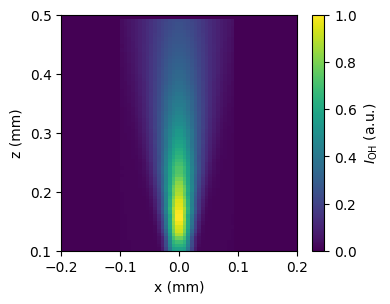

In [54]:
def plot_proj(img, filename=''):
    fig, ax = plt.subplots(figsize=(4, 4))
    levels = 64

    cs = ax.imshow(img, extent=(-0.2, 0.2, 0.1, 0.5)) 
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.15)
    ax.set_xlabel('x (mm)')
    ax.set_ylabel('z (mm)')
    ax.set_yticks([0.1, 0.2, 0.3, 0.4, 0.5])
    
    fmt = mpl.ticker.ScalarFormatter(useMathText=True)
    cbar = fig.colorbar(cs, cax=cax, format=fmt)
    cbar.formatter.set_powerlimits((0, 0))
    cbar.set_label(r'$I_{\mathrm{OH}}$ (a.u.)')
    fig.tight_layout()

    if filename != '':
        fig.savefig(filename, transparent=False, dpi=600, bbox_inches='tight')

    plt.show()

i_test = [0, 21, 27, 38] # index of the testing simulations

P_train = np.delete(P, i_test, axis=0)
P_test = P[i_test, :]

X_int_train = np.delete(X_int, i_test, axis=1)
X_int_test = X_int[:, i_test]

img = C.dot(X_int_test[i_feature*n_cells_int:(i_feature+1)*n_cells_int,0]).reshape(n_sensor, n_sensor)
plot_proj(img/img.max())

Finally, we use the sparse sensing algorithm to reconstruct the 3D field from the projections.

In [55]:
from openmeasure.sparse_sensing import SPR
from scipy.sparse import csr_matrix, hstack

C_sps = csr_matrix((C.shape[0], X_int_train.shape[0]))
C_sps[:, i_feature*n_cells_int:(i_feature+1)*n_cells_int] = C

spr = SPR(X_int_train, n_features, xyz_int)  # create the spr object
spr.fit(n_modes=99) # fit the C_sps matrix

# features = ['NOx', 'CO', 'OH', 'H2', 'H2O', 'CO2', 'O2', 'CH4', 'T']
limit_min = np.array([0., 0., 0., 0., 0., 0., 0., 0., 0.])
limit_max = np.array([1., 1., 1., 1., 1., 1., 1., 1., 5000.])
spr.train(C_sps, method='COLS', limits=[limit_min, limit_max], verbose=True) # fit the C_sps matrix

# compute the projections for the testing cases
y_list = [] 
for i in range(X_int_test.shape[1]):
    y = np.zeros((C.shape[0], 3))

    proj = C.dot(X_int_test[i_feature*n_cells_int:(i_feature+1)*n_cells_int,i])
    y[:,0] = proj.flatten()
    y[:,2] = features.index('OH')

    y_list.append(y)

Ar, Ar_sigma = spr.predict(y_list) # predict the low-d projection
X_int_pred = spr.reconstruct(Ar) # reconstruct in the original space


                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Feb 26 04:39:09 PM: Your problem has 9 variables, 2 constraints, and 0 parameters.
(CVXPY) Feb 26 04:39:09 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 26 04:39:09 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 26 04:39:09 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Feb 26 04:39:09 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 26 04:39:09 PM: Compiling problem (target solver=CLARABEL).
(

Now we can plot the observed and predicted OH distribution.

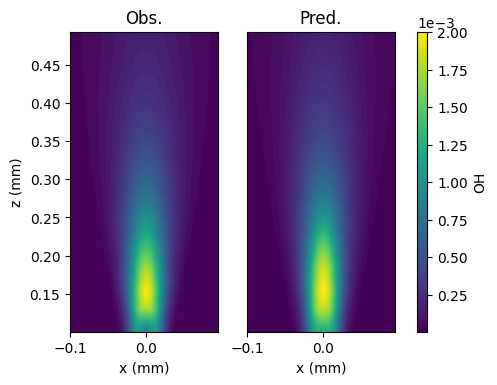

In [56]:
def plot_comparison(mesh, zs, normal, origin, axis, feature, cmap='viridis'):
    n_cases = len(zs)
    cases = ['Obs.', 'Pred.']  
    for i, case in enumerate(cases):
        mesh[case] = zs[i]
        
    plane = mesh.ctp().slice(normal=normal, origin=origin, generate_triangles=True)
    
    vmin = plane[cases[0]].min()
    vmax = plane[cases[0]].max()

    extent_min = [-0.2, -0.2, 0.1]
    extent_max = [0.2, 0.2, 0.5]

    x = plane.points
    tri = plane.faces.reshape((-1,4))[:, 1:]
    
    fig, axs = plt.subplots(ncols=n_cases, figsize=(4, 3))
    levels = 64

    axis_labels = ['x', 'y', 'z']
    fig.subplots_adjust(bottom=0., top=1., left=0, right=.875, wspace=0.025, hspace=0.0)

    for i, ax in enumerate(axs):
        cs = ax.tricontourf(x[:,axis[0]], x[:,axis[1]], tri, plane[cases[i]], cmap=cmap,
                        levels=levels)
        
        ax.set_aspect('equal')
        ax.set_xlabel(f'{axis_labels[axis[0]]} (mm)')
        ax.set_title(cases[i])

        if i > 0:
            ax.tick_params(axis='y', which='both', left=False, labelleft=False)
        else:
            ax.set_ylabel(f'{axis_labels[axis[1]]} (mm)')
    
    
    ax_bounds = axs[1].get_position().bounds
    cb_ax = fig.add_axes([0.9, ax_bounds[1], 0.025, ax_bounds[3]])
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), 
                        cax=cb_ax, orientation='vertical', label=feature)
    fmt = mpl.ticker.ScalarFormatter(useMathText=True)
    cbar.formatter.set_powerlimits((0, 4))
    cb_ax.yaxis.set_offset_position('left')
    
    plt.show()

plot_feature = features.index('OH')

x_test = X_int_test[plot_feature*n_cells_int:(plot_feature+1)*n_cells_int,0]
x_pred = X_int_pred[plot_feature*n_cells_int:(plot_feature+1)*n_cells_int,0]

# plot the comparison of the OH mass fraction on the symmetry plane
plot_comparison(mesh_int, [x_test, x_pred], (0,1,0), (0.0, 1.0e-3, 0), (0,2), 'OH')

Obviously, in this case the flame is symmetric and we could have simply applied the Abel deconvolution to obtain the planar OH distribution. However, with sparse sensing we can also predict the distribution of the other features.

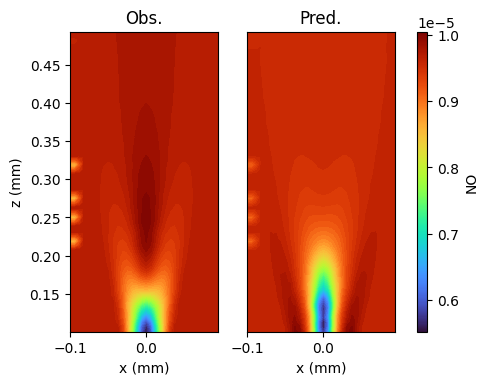

In [59]:
plot_feature = features.index('NOx')

x_test = X_int_test[plot_feature*n_cells_int:(plot_feature+1)*n_cells_int,0]
x_pred = X_int_pred[plot_feature*n_cells_int:(plot_feature+1)*n_cells_int,0]

# plot the comparison of the NO mass fraction on the symmetry plane
plot_comparison(mesh_int, [x_test, x_pred], (0,1,0), (0.0, 1.0e-3, 0), (0,2), 'NO', 'turbo')